# Redes neuronales en un problema de regresión

In [30]:
from sklearn.datasets import load_boston
%matplotlib inline
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html
boston = load_boston()

In [2]:
import pandas as pd

df = pd.DataFrame( data    = boston['data'],         
                      columns =  boston['feature_names']) 

df['target']=boston['target']

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.593761,8.596783,0.00632,0.082045,0.25651,3.647423,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


En este dataset no tenemos demasiadas variables. Si hubiera demasiadas variables podríamos seleccionar las que estén más correladas con la variable target.

In [5]:
# buscamos las variables más correladas con la variable a predecir
correl=df.corr()
correl['target']

# para mostrar sólo las que superen cierto umbral de correlación
#correl[abs(correl['target']) > 0.5]['target']

CRIM      -0.385832
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
target     1.000000
Name: target, dtype: float64

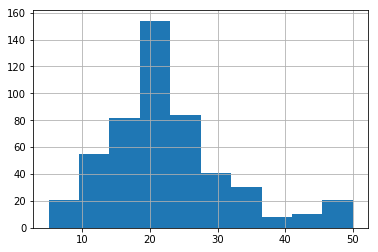

In [31]:
df.target.hist()

Observamos una distribución asimétrica a la derecha y con un número de observaciones anormalmente alto en la última barra.

## Re-escalado de los datos

In [6]:
from sklearn.preprocessing import StandardScaler

# Transformamos las variables de entrada
scaler_x = StandardScaler()
scaler_x.fit(boston.data)
boston_scaled=scaler_x.transform(boston.data)

# Y también transformamos la variable de salida
scaler_y = StandardScaler()
scaler_y.fit(boston.target.reshape(-1, 1)) # Como es una sola variable es necesario ponerlo en modo columna
target_scaled=scaler_y.transform(boston.target.reshape(-1, 1))


## Buscamos el mejor coeficiente de regularización usando validación cruzada

In [17]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np


regul_param_range = 10.0 ** -np.arange(1, 7) 

cv_scores_mean=[]
cv_scores_std=[]

for regul_param in regul_param_range:
    # aumentamos el parámetro max_iter hasta que converja
    mlp=MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=regul_param, batch_size=100, 
             learning_rate='constant', learning_rate_init=0.001, max_iter=350, random_state=333)
    
    # El error es neg_mean_squared_error el MSE en negativo!! Más pequeño peor.
    scores = cross_val_score(mlp, boston_scaled, target_scaled.ravel(), cv=5, scoring='neg_mean_squared_error')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
    

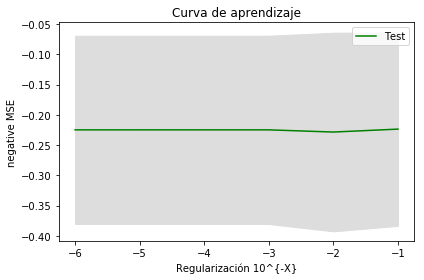

In [18]:
import matplotlib.pyplot as plt

# Dibujamos la línea de la exactitud media en las partes de test
# Como el 
plt.plot(np.log10(regul_param_range), cv_scores_mean, color="g", label="Test")

# Dibujamos la banda de la desviación típica
lower_limit=np.array(cv_scores_mean)-np.array(cv_scores_std)
upper_limit=np.array(cv_scores_mean)+np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("Regularización 10^{-X}"), plt.ylabel("negative MSE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Podemos obsevar un comportamiento bastante estable para este parámetro. Cualquier valor entre $10^{-6}$ y $10^{-3}$ ofrece el mismo comportamiento en media y desviación típica.

## Análisis del error

Vamos a analizar el error que comete el perceptrón con los datos originales y el valor del parámetro de regularización elegido

NOTA: Este análisis que vamos a calcular no son obtenidas por un único perceptrón, sino por una agregación de los k perceptrones estimados en el k-fold

In [22]:
from sklearn.model_selection import cross_val_predict


regul_param=10**-2

mlp=MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=regul_param, batch_size=100, 
             learning_rate='constant', learning_rate_init=0.001, max_iter=350, random_state=333)
    

predicts_scaled = cross_val_predict(mlp, boston_scaled, target_scaled.ravel(), cv=5)


# escalamos las predicciones para que estén en la escala original
predicts=scaler_y.inverse_transform(predicts_scaled)



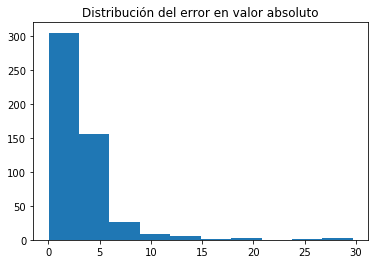

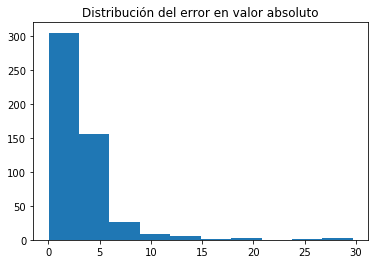

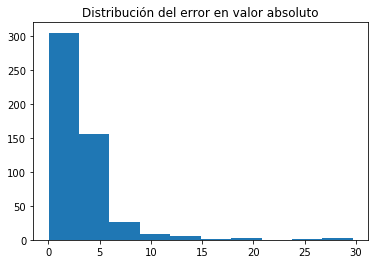

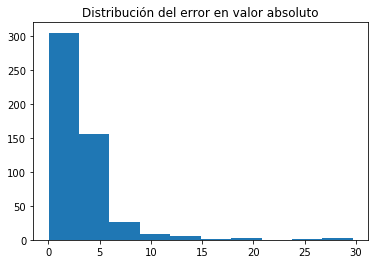

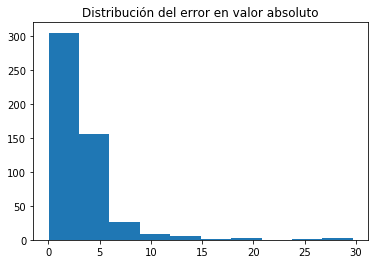

In [25]:
# Dibujamos el histograma de los errores
fig1 = plt.figure()
ax1 = plt.axes()
ax1.hist(np.abs(boston.target - predicts))  # np.abs(boston.target - predicts) es el error en cada ejemplo

plt.title('Distribución del error en valor absoluto')
plt.show()

La distribución del error muestra algunos valores demasiado elevados que no son deseables

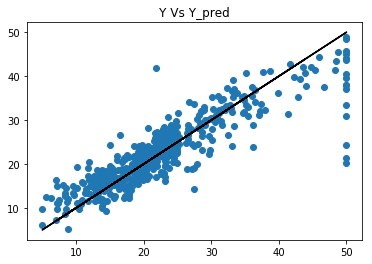

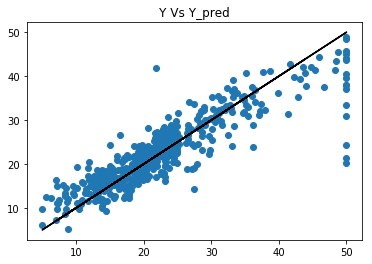

In [27]:
fig2 = plt.figure()
ax2 = plt.axes()

# dibujamos los errores: la distancia a la recta indica el nivel de error
ax2.scatter(boston.target, predicts) 
# Pintamos la referencia de la predicción perfecta
ax2.plot(boston.target, boston.target, color='k') 

plt.title('Y Vs Y_pred')
plt.show()

Al pintar el gráfico vemos que la mayor desviación se produce para los valores de Y=50.

Esto seguramente quiere decir que se pueda mejorar la estimación y que hay que hacer algo con los valores superiores del rango.